<a href="https://colab.research.google.com/github/mitrasubham/OpenCVLLM/blob/main/Table_detection_and_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab.patches import cv2_imshow

In [2]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 19.8 MB/s eta 0:00:00


In [3]:
import easyocr
reader = easyocr.Reader(['th','en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [4]:
import pandas as pd
import cv2
import numpy as np

In [9]:

def table_detection(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, img_bin) = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bin = cv2.bitwise_not(img_bin)

    kernel_length_v = (np.array(img_gray).shape[1])//120
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length_v))
    im_temp1 = cv2.erode(img_bin, vertical_kernel, iterations=3)
    vertical_lines_img = cv2.dilate(im_temp1, vertical_kernel, iterations=3)

    kernel_length_h = (np.array(img_gray).shape[1])//40
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length_h, 1))
    im_temp2 = cv2.erode(img_bin, horizontal_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(im_temp2, horizontal_kernel, iterations=3)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    table_segment = cv2.addWeighted(vertical_lines_img, 0.5, horizontal_lines_img, 0.5, 0.0)
    table_segment = cv2.erode(cv2.bitwise_not(table_segment), kernel, iterations=2)
    thresh, table_segment = cv2.threshold(table_segment, 0, 255, cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(table_segment, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    count = 0

    full_list=[]
    row=[]
    data=[]
    first_iter=0
    firsty=-1


    for c in contours:
        x, y, w, h = cv2.boundingRect(c)

        if  h > 9 and h<100:
            if first_iter==0:
              first_iter=1
              firsty=y
            if firsty!=y:
              row.reverse()
              full_list.append(row)
              row=[]
              data=[]
            print(x,y,w,h)
            cropped = img[y:y + h, x:x + w]
            cv2_imshow(cropped)
            bounds = reader.readtext(cropped)


            try:
              data.append(bounds[0][1])
              data.append(w)
              row.append(data)
              data=[]
            except:
              data.append("--")
              data.append(w)
              row.append(data)
              data=[]
            firsty=y
        cv2.rectangle(img,(x, y),(x + w, y + h),(0, 255, 0), 2)
        cv2_imshow(img)
    full_list.reverse()
    print(full_list)

    new_data=[]
    new_row=[]
    for i in full_list:
      for j in i:
        new_row.append(j[0])
      new_data.append(new_row)
      new_row=[]
    print(new_data)

    # Convert list of lists into a DataFrame
    df = pd.DataFrame(new_data)
    df = df.map(lambda x: '' if pd.isna(x) else x)
    from tabulate import tabulate
    #table = tabulate(df, headers='firstrow', tablefmt='grid')
    table = tabulate(df, tablefmt='grid')

    # Print DataFrame
    print(table)



441 3 120 31


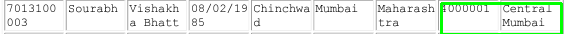

379 3 57 31


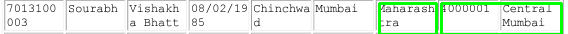

254 3 120 31


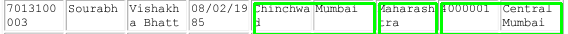

130 3 119 31


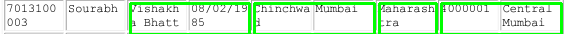

69 3 56 31


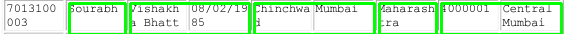

7 3 57 31


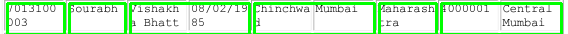

566 0 2 34


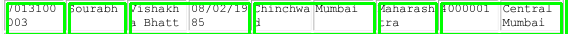

0 0 2 34


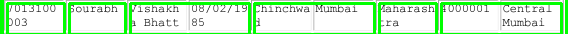

[[['7013100', 57], ['sourabh', 56], ['shaln', 119], ['sh inchwa murbal', 120], ['ata taan', 57], ['เตด0001', 120]]]
[['7013100', 'sourabh', 'shaln', 'sh inchwa murbal', 'ata taan', 'เตด0001']]
+---+---------+---------+-------+------------------+----------+---------+
| 0 | 7013100 | sourabh | shaln | sh inchwa murbal | ata taan | เตด0001 |
+---+---------+---------+-------+------------------+----------+---------+


In [10]:
table_detection("singleline.png")